Tutorial from: https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac

In [166]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from typing import Any, Callable, Dict, List, Optional, Tuple
import MyMnistDataset

class MyDataLoader(torchvision.datasets.MNIST):


    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:x
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        resize_transform = transforms.Compose([
            transforms.Resize((20, 20))
        ])
        img, _ = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode="L")
        small_img = resize_transform(img)

        if self.transform is not None:
            img = self.transform(img)
            small_img = self.transform(small_img)

        return img, small_img

data_dir = 'mydataset'

train_dataset = MyDataLoader(data_dir, train=True, download=True)
test_dataset  = MyDataLoader(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [167]:
class SmallEncoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(2 * 2 * 32, 64),
            nn.ReLU(True),
            nn.Linear(64, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class BigEncoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class SmallDecoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 2 * 2 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,
                                      unflattened_size=(32, 2, 2))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3,
                               stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2,
                               padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

class BigDecoder(nn.Module):
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,
                                      unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3,
                               stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2,
                               padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [168]:

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 32

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = SmallEncoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = BigDecoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


BigDecoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [169]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, small_image_batch in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        small_image_batch = small_image_batch.to(device)
        # Encode data
        encoded_data = encoder(small_image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [170]:

### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, small_image_batch in dataloader:
            # Move tensor to the proper device
            small_image_batch = small_image_batch.to(device)
            # Encode data
            encoded_data = encoder(small_image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [171]:

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      size_index = 0 #  for 28x28
      size_index = 1 #  for 20x20
      img = test_dataset[t_idx[i]][size_index].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(test_dataset[t_idx[i]][0].unsqueeze(0).to(device).cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

In [172]:
# diz_loss = {'train_loss':[],'val_loss':[]}

	 partial train loss (single batch): 0.245576
	 partial train loss (single batch): 0.239650
	 partial train loss (single batch): 0.236082
	 partial train loss (single batch): 0.232069
	 partial train loss (single batch): 0.229006
	 partial train loss (single batch): 0.226282
	 partial train loss (single batch): 0.223715
	 partial train loss (single batch): 0.221488
	 partial train loss (single batch): 0.218924
	 partial train loss (single batch): 0.217651
	 partial train loss (single batch): 0.215428
	 partial train loss (single batch): 0.213996
	 partial train loss (single batch): 0.211874
	 partial train loss (single batch): 0.210060
	 partial train loss (single batch): 0.208560
	 partial train loss (single batch): 0.206534
	 partial train loss (single batch): 0.204803
	 partial train loss (single batch): 0.203060
	 partial train loss (single batch): 0.201977
	 partial train loss (single batch): 0.199894
	 partial train loss (single batch): 0.198263
	 partial train loss (single batch

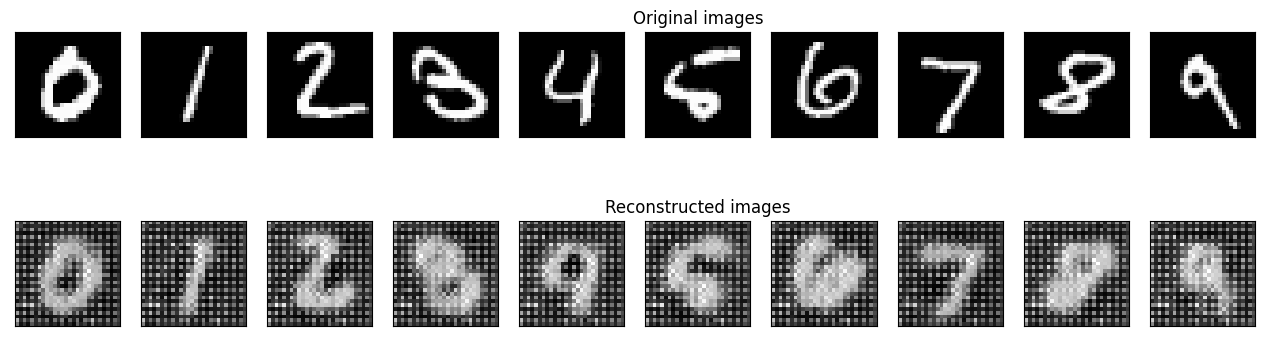

	 partial train loss (single batch): 0.077378
	 partial train loss (single batch): 0.077274
	 partial train loss (single batch): 0.076263
	 partial train loss (single batch): 0.076725
	 partial train loss (single batch): 0.076850
	 partial train loss (single batch): 0.076206
	 partial train loss (single batch): 0.075168
	 partial train loss (single batch): 0.076357
	 partial train loss (single batch): 0.075226
	 partial train loss (single batch): 0.074587
	 partial train loss (single batch): 0.074682
	 partial train loss (single batch): 0.073669
	 partial train loss (single batch): 0.073602
	 partial train loss (single batch): 0.073600
	 partial train loss (single batch): 0.073421
	 partial train loss (single batch): 0.072494
	 partial train loss (single batch): 0.072867
	 partial train loss (single batch): 0.072052
	 partial train loss (single batch): 0.071489
	 partial train loss (single batch): 0.071347
	 partial train loss (single batch): 0.071730
	 partial train loss (single batch

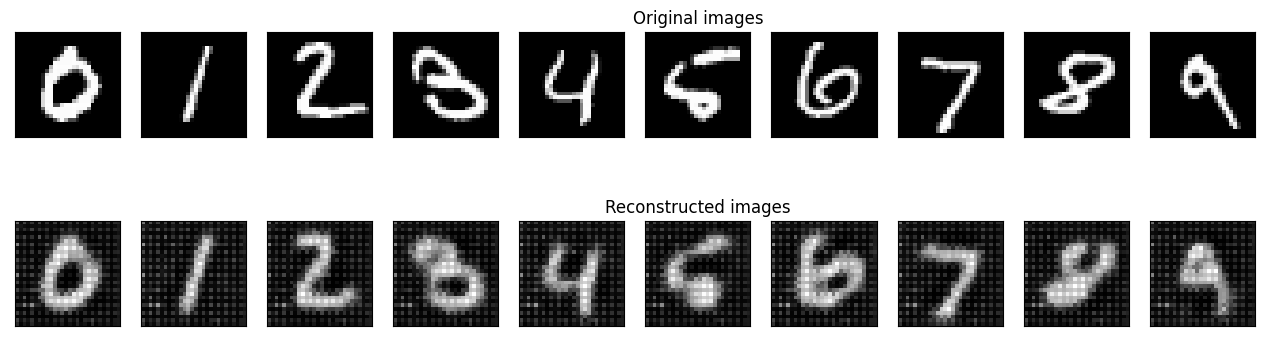

	 partial train loss (single batch): 0.034596
	 partial train loss (single batch): 0.035282
	 partial train loss (single batch): 0.034075
	 partial train loss (single batch): 0.034907
	 partial train loss (single batch): 0.034786
	 partial train loss (single batch): 0.034205
	 partial train loss (single batch): 0.033767
	 partial train loss (single batch): 0.034476
	 partial train loss (single batch): 0.034214
	 partial train loss (single batch): 0.033603
	 partial train loss (single batch): 0.033756
	 partial train loss (single batch): 0.032689
	 partial train loss (single batch): 0.033102
	 partial train loss (single batch): 0.033210
	 partial train loss (single batch): 0.032784
	 partial train loss (single batch): 0.033084
	 partial train loss (single batch): 0.033006
	 partial train loss (single batch): 0.032841
	 partial train loss (single batch): 0.032184
	 partial train loss (single batch): 0.032212
	 partial train loss (single batch): 0.032947
	 partial train loss (single batch

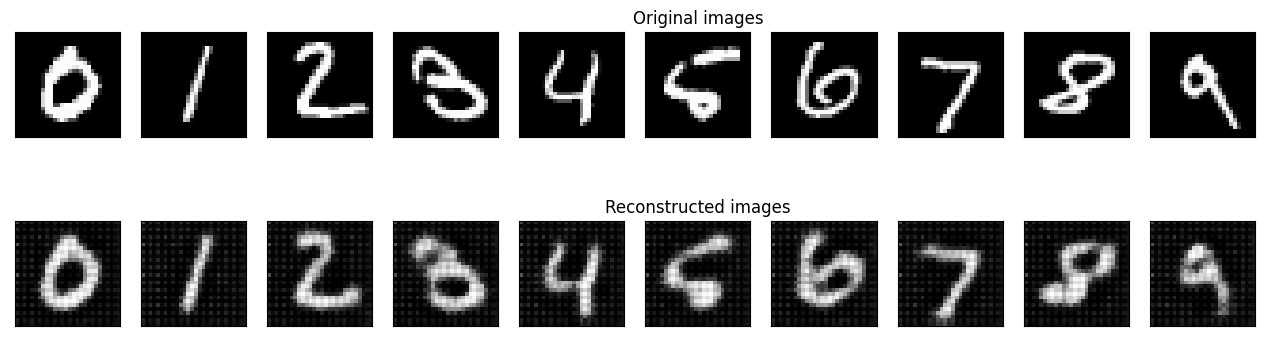

	 partial train loss (single batch): 0.020377
	 partial train loss (single batch): 0.021288
	 partial train loss (single batch): 0.020049
	 partial train loss (single batch): 0.021156
	 partial train loss (single batch): 0.020901
	 partial train loss (single batch): 0.020650
	 partial train loss (single batch): 0.020242
	 partial train loss (single batch): 0.020644
	 partial train loss (single batch): 0.020709
	 partial train loss (single batch): 0.020012
	 partial train loss (single batch): 0.020170
	 partial train loss (single batch): 0.019466
	 partial train loss (single batch): 0.019763
	 partial train loss (single batch): 0.020273
	 partial train loss (single batch): 0.019534
	 partial train loss (single batch): 0.020149
	 partial train loss (single batch): 0.019914
	 partial train loss (single batch): 0.020373
	 partial train loss (single batch): 0.019513
	 partial train loss (single batch): 0.019423
	 partial train loss (single batch): 0.020337
	 partial train loss (single batch

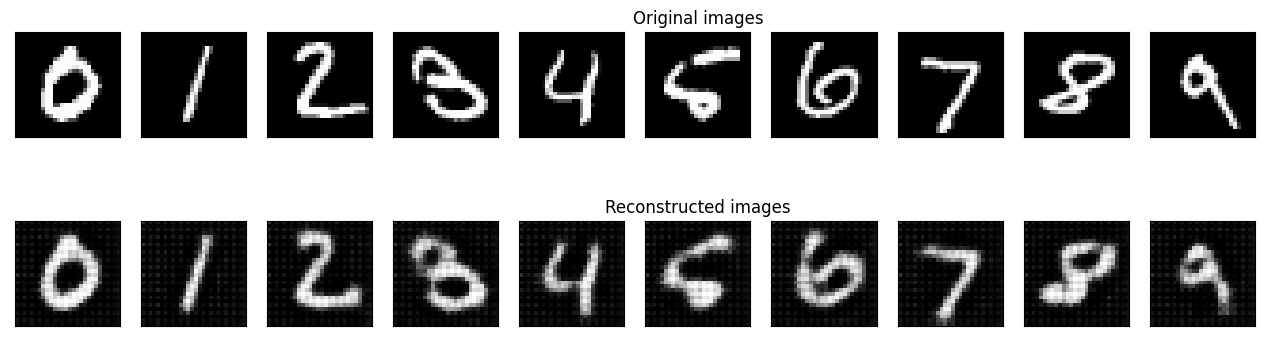

	 partial train loss (single batch): 0.015426
	 partial train loss (single batch): 0.016259
	 partial train loss (single batch): 0.015146
	 partial train loss (single batch): 0.016073
	 partial train loss (single batch): 0.015921
	 partial train loss (single batch): 0.015605
	 partial train loss (single batch): 0.015065
	 partial train loss (single batch): 0.015742
	 partial train loss (single batch): 0.015719
	 partial train loss (single batch): 0.015060
	 partial train loss (single batch): 0.015318
	 partial train loss (single batch): 0.014664
	 partial train loss (single batch): 0.014992
	 partial train loss (single batch): 0.015334
	 partial train loss (single batch): 0.014892
	 partial train loss (single batch): 0.015577
	 partial train loss (single batch): 0.015009
	 partial train loss (single batch): 0.015990
	 partial train loss (single batch): 0.014919
	 partial train loss (single batch): 0.014759
	 partial train loss (single batch): 0.015699
	 partial train loss (single batch

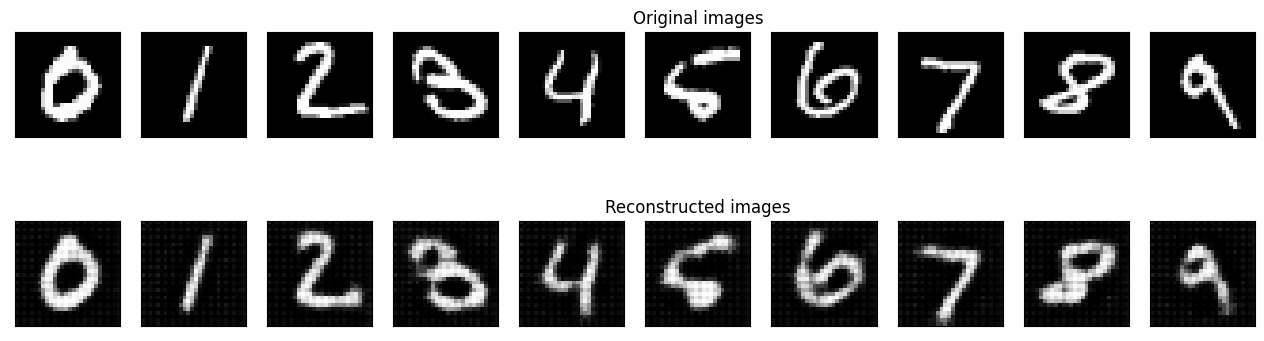

	 partial train loss (single batch): 0.012945
	 partial train loss (single batch): 0.013671
	 partial train loss (single batch): 0.012550
	 partial train loss (single batch): 0.013755
	 partial train loss (single batch): 0.013211
	 partial train loss (single batch): 0.013120
	 partial train loss (single batch): 0.012517
	 partial train loss (single batch): 0.013242
	 partial train loss (single batch): 0.013194
	 partial train loss (single batch): 0.012495
	 partial train loss (single batch): 0.012972
	 partial train loss (single batch): 0.012122
	 partial train loss (single batch): 0.012586
	 partial train loss (single batch): 0.012968
	 partial train loss (single batch): 0.012580
	 partial train loss (single batch): 0.013103
	 partial train loss (single batch): 0.012663
	 partial train loss (single batch): 0.013535
	 partial train loss (single batch): 0.012508
	 partial train loss (single batch): 0.012210
	 partial train loss (single batch): 0.013175
	 partial train loss (single batch

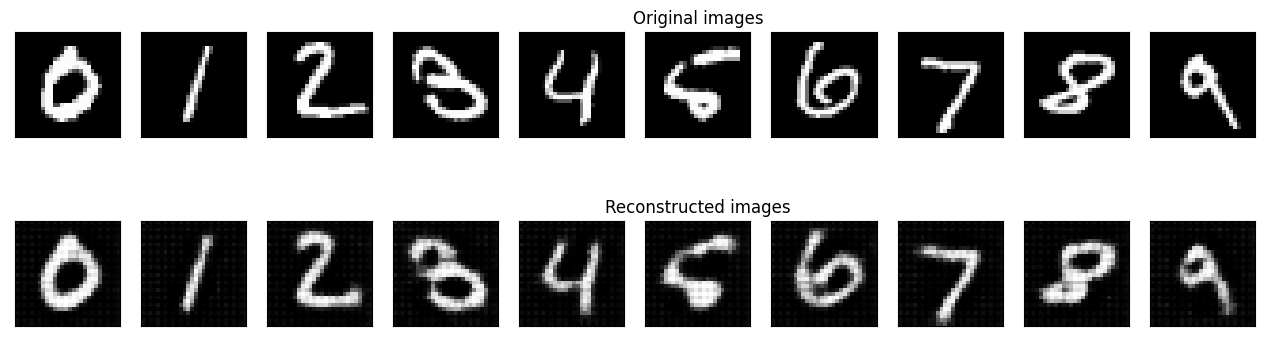

	 partial train loss (single batch): 0.011530
	 partial train loss (single batch): 0.011941
	 partial train loss (single batch): 0.011123
	 partial train loss (single batch): 0.012230
	 partial train loss (single batch): 0.011581
	 partial train loss (single batch): 0.011694
	 partial train loss (single batch): 0.011149
	 partial train loss (single batch): 0.011741
	 partial train loss (single batch): 0.011689
	 partial train loss (single batch): 0.011241
	 partial train loss (single batch): 0.011347
	 partial train loss (single batch): 0.010650
	 partial train loss (single batch): 0.011206
	 partial train loss (single batch): 0.011463
	 partial train loss (single batch): 0.010917
	 partial train loss (single batch): 0.011491
	 partial train loss (single batch): 0.011256
	 partial train loss (single batch): 0.011822
	 partial train loss (single batch): 0.011046
	 partial train loss (single batch): 0.010813
	 partial train loss (single batch): 0.011718
	 partial train loss (single batch

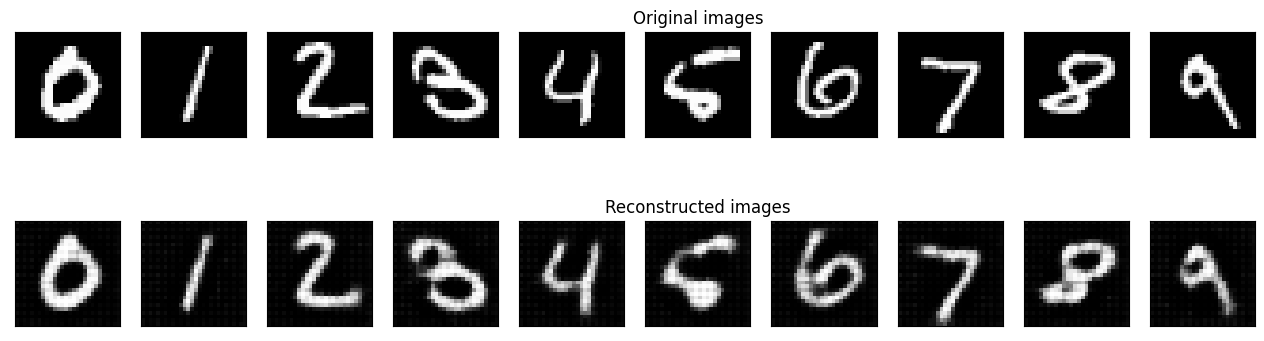

	 partial train loss (single batch): 0.010725
	 partial train loss (single batch): 0.011001
	 partial train loss (single batch): 0.010416
	 partial train loss (single batch): 0.011298
	 partial train loss (single batch): 0.010578
	 partial train loss (single batch): 0.010967
	 partial train loss (single batch): 0.010105
	 partial train loss (single batch): 0.010865
	 partial train loss (single batch): 0.010867
	 partial train loss (single batch): 0.010359
	 partial train loss (single batch): 0.010392
	 partial train loss (single batch): 0.009889
	 partial train loss (single batch): 0.010132
	 partial train loss (single batch): 0.010582
	 partial train loss (single batch): 0.010057
	 partial train loss (single batch): 0.010528
	 partial train loss (single batch): 0.010434
	 partial train loss (single batch): 0.010981
	 partial train loss (single batch): 0.010084
	 partial train loss (single batch): 0.010163
	 partial train loss (single batch): 0.010674
	 partial train loss (single batch

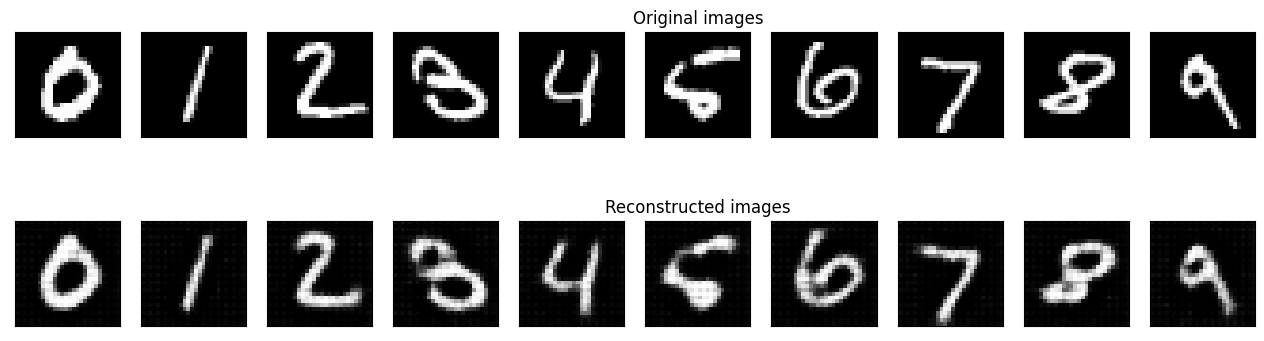

	 partial train loss (single batch): 0.009967
	 partial train loss (single batch): 0.010235
	 partial train loss (single batch): 0.009470
	 partial train loss (single batch): 0.010447
	 partial train loss (single batch): 0.009882
	 partial train loss (single batch): 0.010118
	 partial train loss (single batch): 0.009424
	 partial train loss (single batch): 0.010124
	 partial train loss (single batch): 0.010114
	 partial train loss (single batch): 0.009598
	 partial train loss (single batch): 0.009921
	 partial train loss (single batch): 0.009203
	 partial train loss (single batch): 0.009464
	 partial train loss (single batch): 0.009834
	 partial train loss (single batch): 0.009318
	 partial train loss (single batch): 0.009833
	 partial train loss (single batch): 0.009750
	 partial train loss (single batch): 0.010334
	 partial train loss (single batch): 0.009442
	 partial train loss (single batch): 0.009534
	 partial train loss (single batch): 0.010119
	 partial train loss (single batch

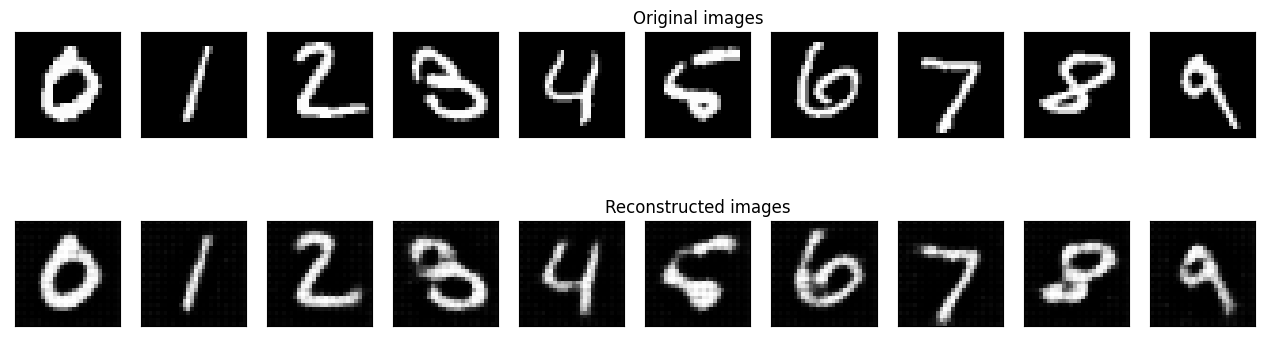

	 partial train loss (single batch): 0.009381
	 partial train loss (single batch): 0.009671
	 partial train loss (single batch): 0.008902
	 partial train loss (single batch): 0.009865
	 partial train loss (single batch): 0.009270
	 partial train loss (single batch): 0.009498
	 partial train loss (single batch): 0.008955
	 partial train loss (single batch): 0.009532
	 partial train loss (single batch): 0.009479
	 partial train loss (single batch): 0.009033
	 partial train loss (single batch): 0.009341
	 partial train loss (single batch): 0.008631
	 partial train loss (single batch): 0.008894
	 partial train loss (single batch): 0.009379
	 partial train loss (single batch): 0.008744
	 partial train loss (single batch): 0.009310
	 partial train loss (single batch): 0.009293
	 partial train loss (single batch): 0.009679
	 partial train loss (single batch): 0.009000
	 partial train loss (single batch): 0.009004
	 partial train loss (single batch): 0.009514
	 partial train loss (single batch

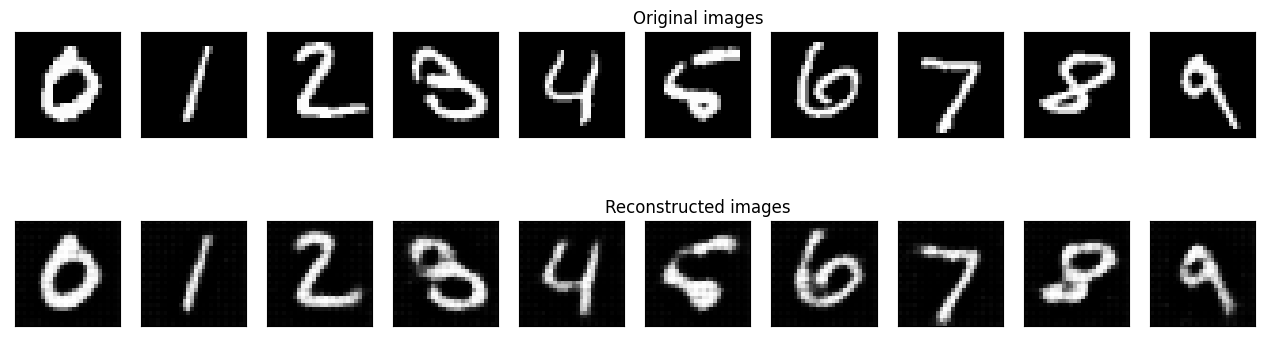

	 partial train loss (single batch): 0.008944
	 partial train loss (single batch): 0.009206
	 partial train loss (single batch): 0.008513
	 partial train loss (single batch): 0.009525
	 partial train loss (single batch): 0.008794
	 partial train loss (single batch): 0.009116
	 partial train loss (single batch): 0.008605
	 partial train loss (single batch): 0.009053
	 partial train loss (single batch): 0.009082
	 partial train loss (single batch): 0.008696
	 partial train loss (single batch): 0.008807
	 partial train loss (single batch): 0.008303
	 partial train loss (single batch): 0.008544
	 partial train loss (single batch): 0.008965
	 partial train loss (single batch): 0.008408
	 partial train loss (single batch): 0.008897
	 partial train loss (single batch): 0.008860
	 partial train loss (single batch): 0.009293
	 partial train loss (single batch): 0.008669
	 partial train loss (single batch): 0.008532
	 partial train loss (single batch): 0.009110
	 partial train loss (single batch

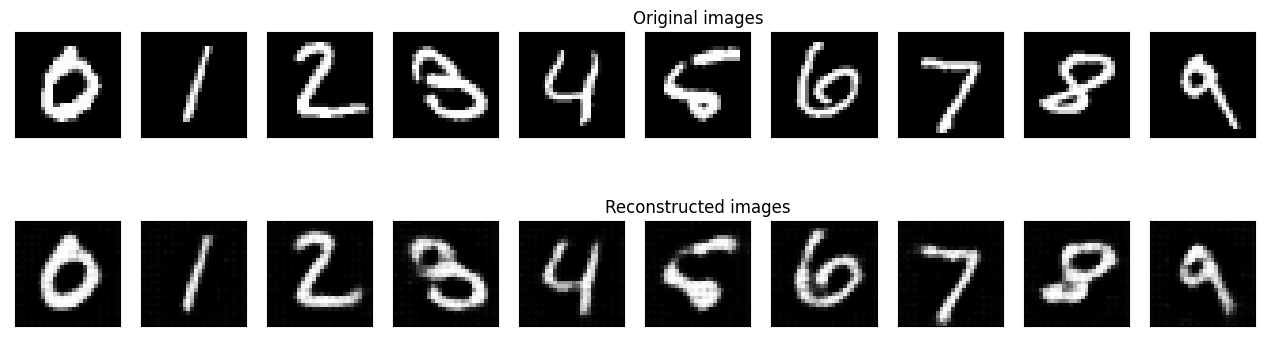

	 partial train loss (single batch): 0.008625
	 partial train loss (single batch): 0.008866
	 partial train loss (single batch): 0.008200
	 partial train loss (single batch): 0.009199
	 partial train loss (single batch): 0.008470
	 partial train loss (single batch): 0.008815
	 partial train loss (single batch): 0.008358
	 partial train loss (single batch): 0.008742
	 partial train loss (single batch): 0.008824
	 partial train loss (single batch): 0.008322
	 partial train loss (single batch): 0.008485
	 partial train loss (single batch): 0.008022
	 partial train loss (single batch): 0.008239
	 partial train loss (single batch): 0.008721
	 partial train loss (single batch): 0.008165
	 partial train loss (single batch): 0.008586
	 partial train loss (single batch): 0.008553
	 partial train loss (single batch): 0.008967
	 partial train loss (single batch): 0.008406
	 partial train loss (single batch): 0.008159
	 partial train loss (single batch): 0.008846
	 partial train loss (single batch

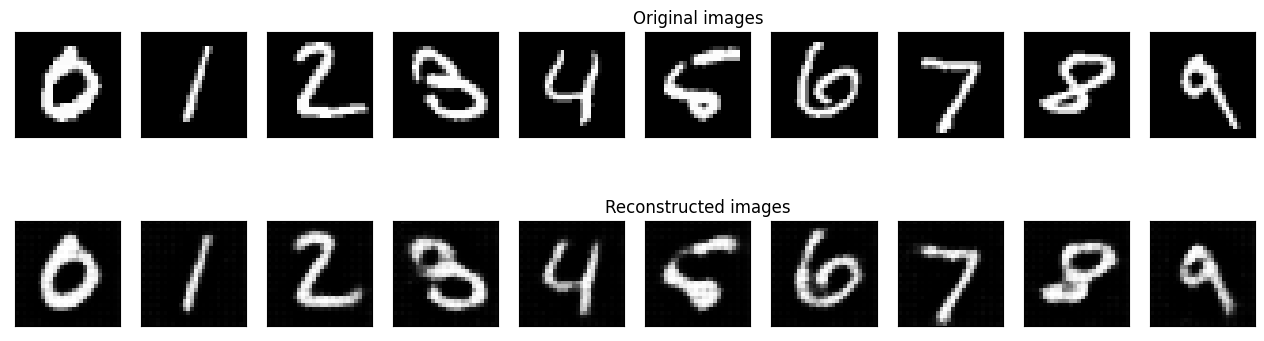

	 partial train loss (single batch): 0.008341
	 partial train loss (single batch): 0.008556
	 partial train loss (single batch): 0.007940
	 partial train loss (single batch): 0.008905
	 partial train loss (single batch): 0.008161
	 partial train loss (single batch): 0.008602
	 partial train loss (single batch): 0.008065
	 partial train loss (single batch): 0.008478
	 partial train loss (single batch): 0.008579
	 partial train loss (single batch): 0.008023
	 partial train loss (single batch): 0.008223
	 partial train loss (single batch): 0.007799
	 partial train loss (single batch): 0.007977
	 partial train loss (single batch): 0.008446
	 partial train loss (single batch): 0.007869
	 partial train loss (single batch): 0.008293
	 partial train loss (single batch): 0.008256
	 partial train loss (single batch): 0.008710
	 partial train loss (single batch): 0.008090
	 partial train loss (single batch): 0.007890
	 partial train loss (single batch): 0.008558
	 partial train loss (single batch

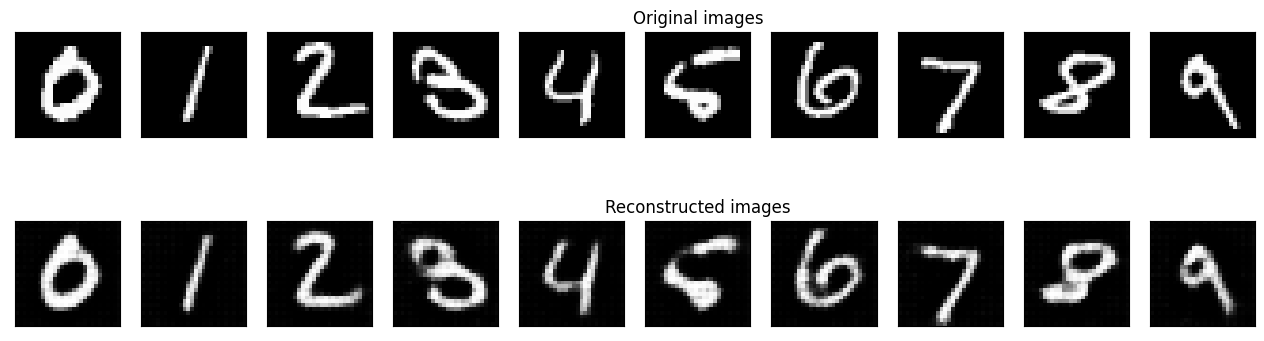

	 partial train loss (single batch): 0.008048
	 partial train loss (single batch): 0.008316
	 partial train loss (single batch): 0.007744
	 partial train loss (single batch): 0.008623
	 partial train loss (single batch): 0.007936
	 partial train loss (single batch): 0.008374
	 partial train loss (single batch): 0.007810
	 partial train loss (single batch): 0.008254
	 partial train loss (single batch): 0.008334
	 partial train loss (single batch): 0.007788
	 partial train loss (single batch): 0.008007
	 partial train loss (single batch): 0.007604
	 partial train loss (single batch): 0.007794
	 partial train loss (single batch): 0.008198
	 partial train loss (single batch): 0.007693
	 partial train loss (single batch): 0.008060
	 partial train loss (single batch): 0.008029
	 partial train loss (single batch): 0.008520
	 partial train loss (single batch): 0.007870
	 partial train loss (single batch): 0.007684
	 partial train loss (single batch): 0.008341
	 partial train loss (single batch

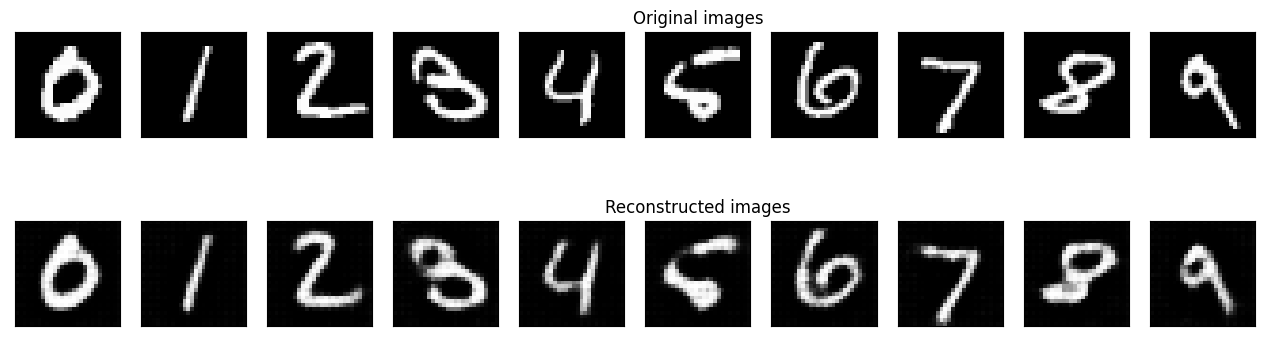

	 partial train loss (single batch): 0.007840
	 partial train loss (single batch): 0.008180
	 partial train loss (single batch): 0.007594
	 partial train loss (single batch): 0.008441
	 partial train loss (single batch): 0.007840
	 partial train loss (single batch): 0.008204
	 partial train loss (single batch): 0.007682
	 partial train loss (single batch): 0.008106
	 partial train loss (single batch): 0.008268
	 partial train loss (single batch): 0.007603
	 partial train loss (single batch): 0.007917
	 partial train loss (single batch): 0.007519
	 partial train loss (single batch): 0.007705
	 partial train loss (single batch): 0.007977
	 partial train loss (single batch): 0.007603
	 partial train loss (single batch): 0.007847
	 partial train loss (single batch): 0.007881
	 partial train loss (single batch): 0.008436
	 partial train loss (single batch): 0.007592
	 partial train loss (single batch): 0.007575
	 partial train loss (single batch): 0.008220
	 partial train loss (single batch

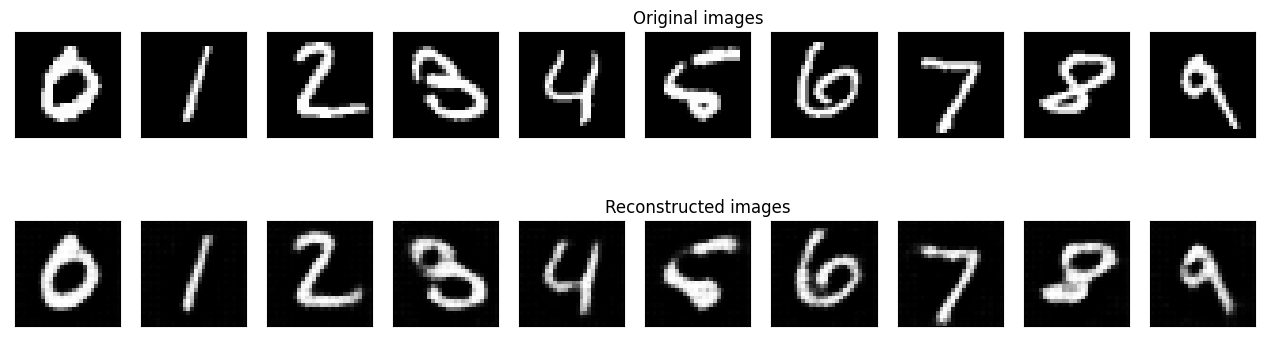

	 partial train loss (single batch): 0.007655
	 partial train loss (single batch): 0.007967
	 partial train loss (single batch): 0.007458
	 partial train loss (single batch): 0.008261
	 partial train loss (single batch): 0.007719
	 partial train loss (single batch): 0.008060
	 partial train loss (single batch): 0.007897
	 partial train loss (single batch): 0.009236
	 partial train loss (single batch): 0.009329
	 partial train loss (single batch): 0.007620
	 partial train loss (single batch): 0.008794
	 partial train loss (single batch): 0.007740
	 partial train loss (single batch): 0.007875
	 partial train loss (single batch): 0.008434
	 partial train loss (single batch): 0.007726
	 partial train loss (single batch): 0.008012
	 partial train loss (single batch): 0.008020
	 partial train loss (single batch): 0.008556
	 partial train loss (single batch): 0.007558
	 partial train loss (single batch): 0.007769
	 partial train loss (single batch): 0.008069
	 partial train loss (single batch

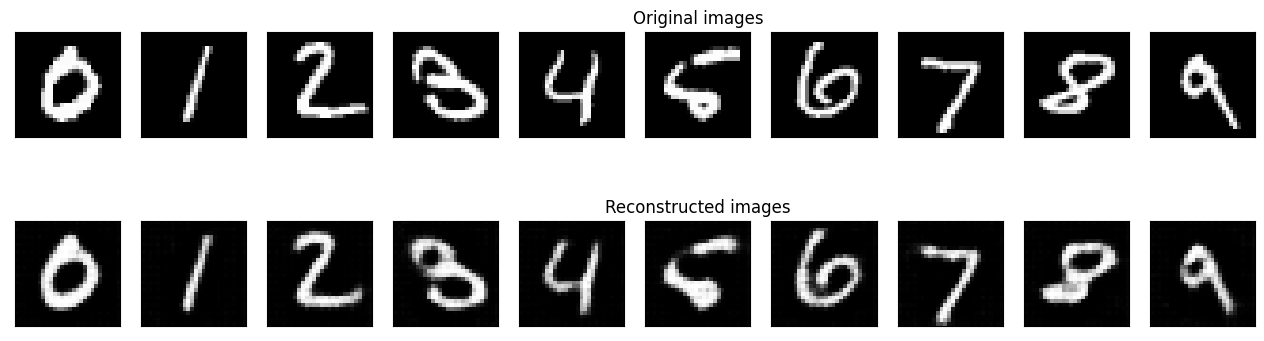

	 partial train loss (single batch): 0.007437
	 partial train loss (single batch): 0.007829
	 partial train loss (single batch): 0.007254
	 partial train loss (single batch): 0.008078
	 partial train loss (single batch): 0.007550
	 partial train loss (single batch): 0.007879
	 partial train loss (single batch): 0.007352
	 partial train loss (single batch): 0.007866
	 partial train loss (single batch): 0.007984
	 partial train loss (single batch): 0.007269
	 partial train loss (single batch): 0.007763
	 partial train loss (single batch): 0.007167
	 partial train loss (single batch): 0.007375
	 partial train loss (single batch): 0.007674
	 partial train loss (single batch): 0.007257
	 partial train loss (single batch): 0.007488
	 partial train loss (single batch): 0.007576
	 partial train loss (single batch): 0.008043
	 partial train loss (single batch): 0.007195
	 partial train loss (single batch): 0.007275
	 partial train loss (single batch): 0.007777
	 partial train loss (single batch

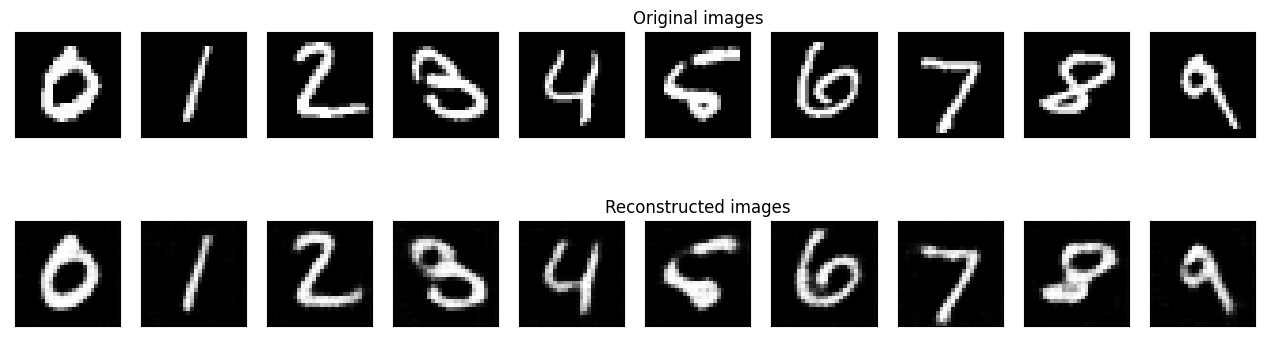

	 partial train loss (single batch): 0.007260
	 partial train loss (single batch): 0.007719
	 partial train loss (single batch): 0.007158
	 partial train loss (single batch): 0.007895
	 partial train loss (single batch): 0.007459
	 partial train loss (single batch): 0.007716
	 partial train loss (single batch): 0.007231
	 partial train loss (single batch): 0.007732
	 partial train loss (single batch): 0.007873
	 partial train loss (single batch): 0.007101
	 partial train loss (single batch): 0.007646
	 partial train loss (single batch): 0.006996
	 partial train loss (single batch): 0.007244
	 partial train loss (single batch): 0.007503
	 partial train loss (single batch): 0.007099
	 partial train loss (single batch): 0.007369
	 partial train loss (single batch): 0.007394
	 partial train loss (single batch): 0.007886
	 partial train loss (single batch): 0.007041
	 partial train loss (single batch): 0.007111
	 partial train loss (single batch): 0.007602
	 partial train loss (single batch

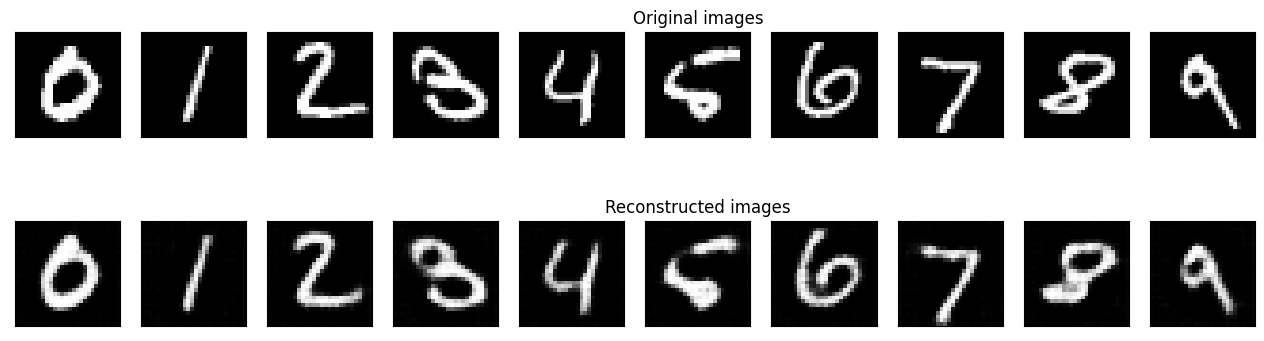

	 partial train loss (single batch): 0.007117
	 partial train loss (single batch): 0.007610
	 partial train loss (single batch): 0.007110
	 partial train loss (single batch): 0.007722
	 partial train loss (single batch): 0.007373
	 partial train loss (single batch): 0.007617
	 partial train loss (single batch): 0.007062
	 partial train loss (single batch): 0.007674
	 partial train loss (single batch): 0.007729
	 partial train loss (single batch): 0.007001
	 partial train loss (single batch): 0.007585
	 partial train loss (single batch): 0.006838
	 partial train loss (single batch): 0.007137
	 partial train loss (single batch): 0.007404
	 partial train loss (single batch): 0.006940
	 partial train loss (single batch): 0.007296
	 partial train loss (single batch): 0.007234
	 partial train loss (single batch): 0.007741
	 partial train loss (single batch): 0.006892
	 partial train loss (single batch): 0.006957
	 partial train loss (single batch): 0.007427
	 partial train loss (single batch

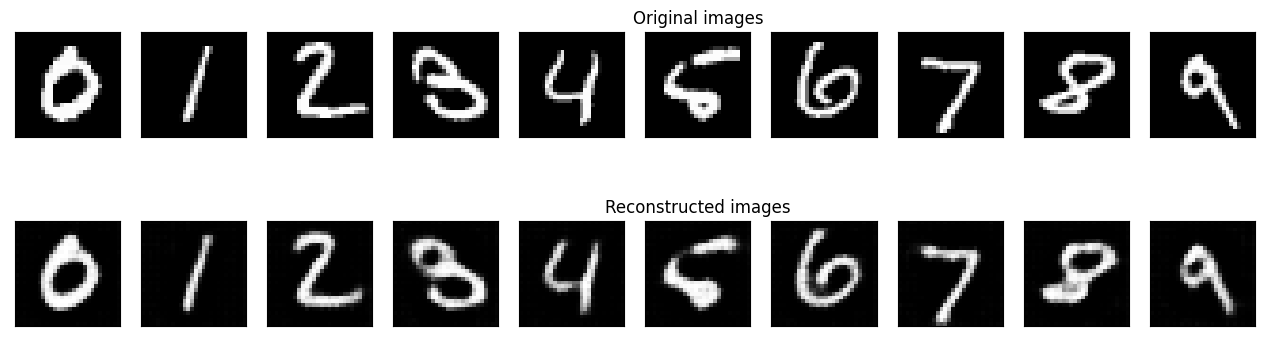

	 partial train loss (single batch): 0.007062
	 partial train loss (single batch): 0.007703
	 partial train loss (single batch): 0.006911
	 partial train loss (single batch): 0.007800
	 partial train loss (single batch): 0.007164
	 partial train loss (single batch): 0.007484
	 partial train loss (single batch): 0.006832
	 partial train loss (single batch): 0.007593
	 partial train loss (single batch): 0.007389
	 partial train loss (single batch): 0.006986
	 partial train loss (single batch): 0.007346
	 partial train loss (single batch): 0.006747
	 partial train loss (single batch): 0.007034
	 partial train loss (single batch): 0.007319
	 partial train loss (single batch): 0.006808
	 partial train loss (single batch): 0.007211
	 partial train loss (single batch): 0.007094
	 partial train loss (single batch): 0.007655
	 partial train loss (single batch): 0.006785
	 partial train loss (single batch): 0.006892
	 partial train loss (single batch): 0.007255
	 partial train loss (single batch

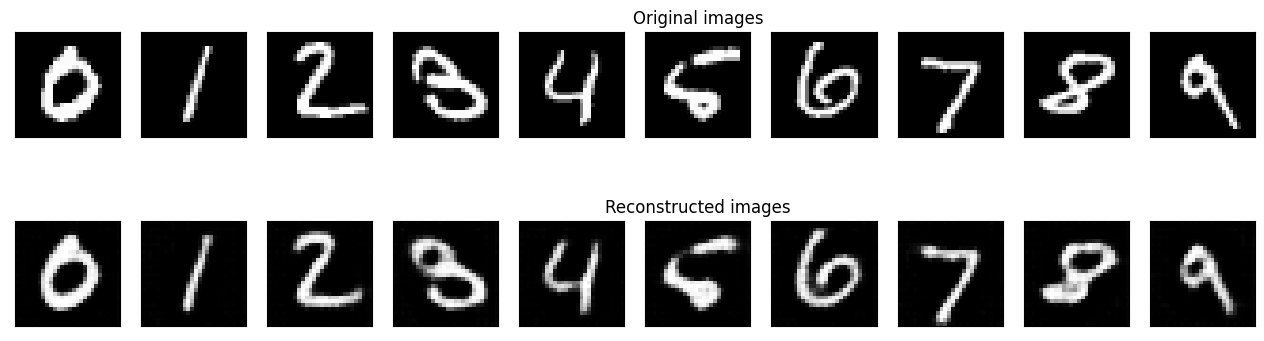

	 partial train loss (single batch): 0.006893
	 partial train loss (single batch): 0.007387
	 partial train loss (single batch): 0.006709
	 partial train loss (single batch): 0.007457
	 partial train loss (single batch): 0.006957
	 partial train loss (single batch): 0.007254
	 partial train loss (single batch): 0.006648
	 partial train loss (single batch): 0.007360
	 partial train loss (single batch): 0.007196
	 partial train loss (single batch): 0.006803
	 partial train loss (single batch): 0.007172
	 partial train loss (single batch): 0.006635
	 partial train loss (single batch): 0.006834
	 partial train loss (single batch): 0.007151
	 partial train loss (single batch): 0.006656
	 partial train loss (single batch): 0.007053
	 partial train loss (single batch): 0.006989
	 partial train loss (single batch): 0.007503
	 partial train loss (single batch): 0.006678
	 partial train loss (single batch): 0.006738
	 partial train loss (single batch): 0.007174
	 partial train loss (single batch

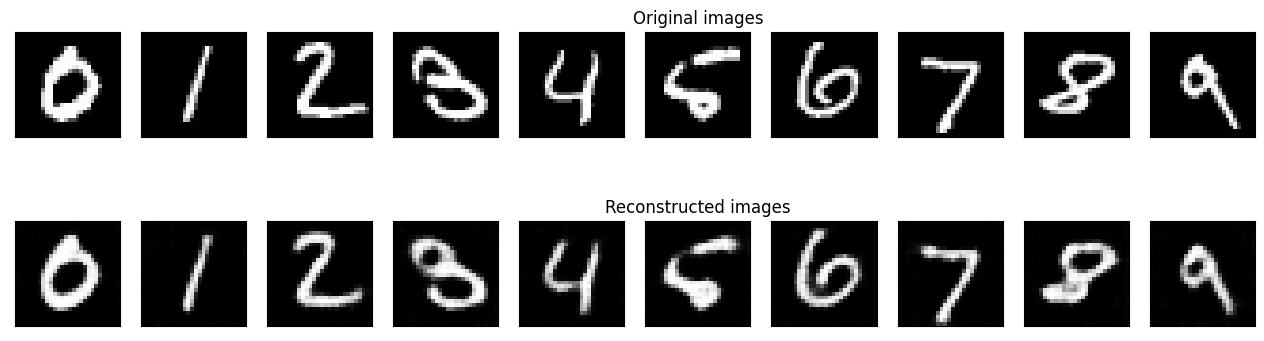

	 partial train loss (single batch): 0.006753
	 partial train loss (single batch): 0.007307
	 partial train loss (single batch): 0.006592
	 partial train loss (single batch): 0.007332
	 partial train loss (single batch): 0.006855
	 partial train loss (single batch): 0.007105
	 partial train loss (single batch): 0.006552
	 partial train loss (single batch): 0.007218
	 partial train loss (single batch): 0.007077
	 partial train loss (single batch): 0.006679
	 partial train loss (single batch): 0.007067
	 partial train loss (single batch): 0.006519
	 partial train loss (single batch): 0.006725
	 partial train loss (single batch): 0.007034
	 partial train loss (single batch): 0.006542
	 partial train loss (single batch): 0.006940
	 partial train loss (single batch): 0.006880
	 partial train loss (single batch): 0.007360
	 partial train loss (single batch): 0.006579
	 partial train loss (single batch): 0.006624
	 partial train loss (single batch): 0.007064
	 partial train loss (single batch

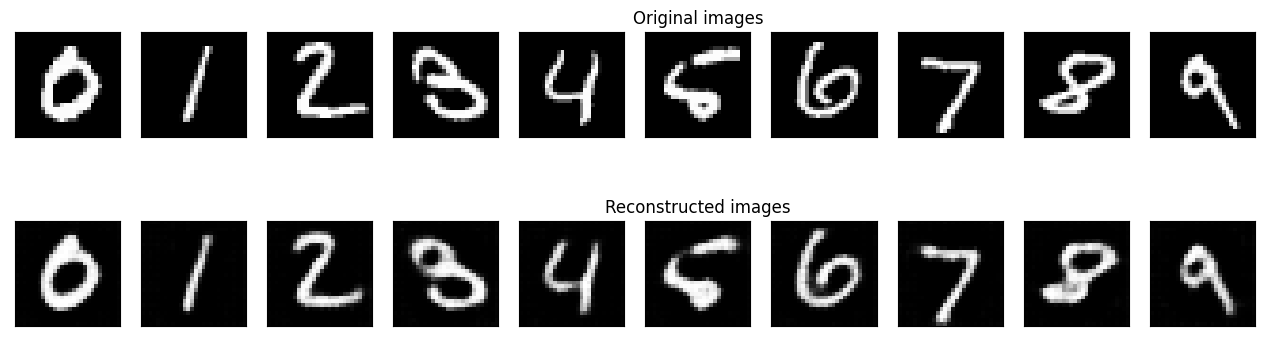

	 partial train loss (single batch): 0.006637
	 partial train loss (single batch): 0.007203
	 partial train loss (single batch): 0.006454
	 partial train loss (single batch): 0.007209
	 partial train loss (single batch): 0.006736
	 partial train loss (single batch): 0.006975
	 partial train loss (single batch): 0.006457
	 partial train loss (single batch): 0.007087
	 partial train loss (single batch): 0.007007
	 partial train loss (single batch): 0.006540
	 partial train loss (single batch): 0.006963
	 partial train loss (single batch): 0.006428
	 partial train loss (single batch): 0.006591
	 partial train loss (single batch): 0.006955
	 partial train loss (single batch): 0.006414
	 partial train loss (single batch): 0.006831
	 partial train loss (single batch): 0.006788
	 partial train loss (single batch): 0.007209
	 partial train loss (single batch): 0.006495
	 partial train loss (single batch): 0.006540
	 partial train loss (single batch): 0.006945
	 partial train loss (single batch

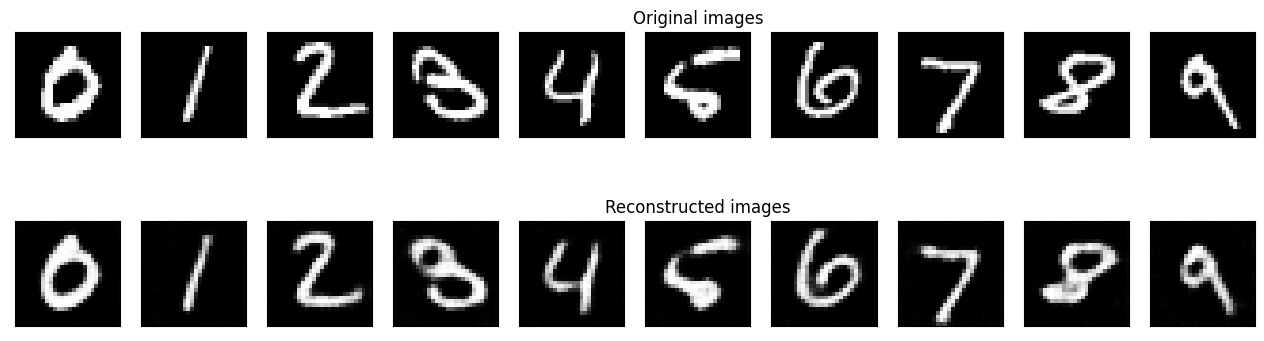

	 partial train loss (single batch): 0.006614
	 partial train loss (single batch): 0.007146
	 partial train loss (single batch): 0.006323
	 partial train loss (single batch): 0.007161
	 partial train loss (single batch): 0.006629
	 partial train loss (single batch): 0.006870
	 partial train loss (single batch): 0.006387
	 partial train loss (single batch): 0.006904
	 partial train loss (single batch): 0.006949
	 partial train loss (single batch): 0.006379
	 partial train loss (single batch): 0.006867
	 partial train loss (single batch): 0.006377
	 partial train loss (single batch): 0.006415
	 partial train loss (single batch): 0.006901
	 partial train loss (single batch): 0.006286
	 partial train loss (single batch): 0.006746
	 partial train loss (single batch): 0.006736
	 partial train loss (single batch): 0.007106
	 partial train loss (single batch): 0.006371
	 partial train loss (single batch): 0.006471
	 partial train loss (single batch): 0.006874
	 partial train loss (single batch

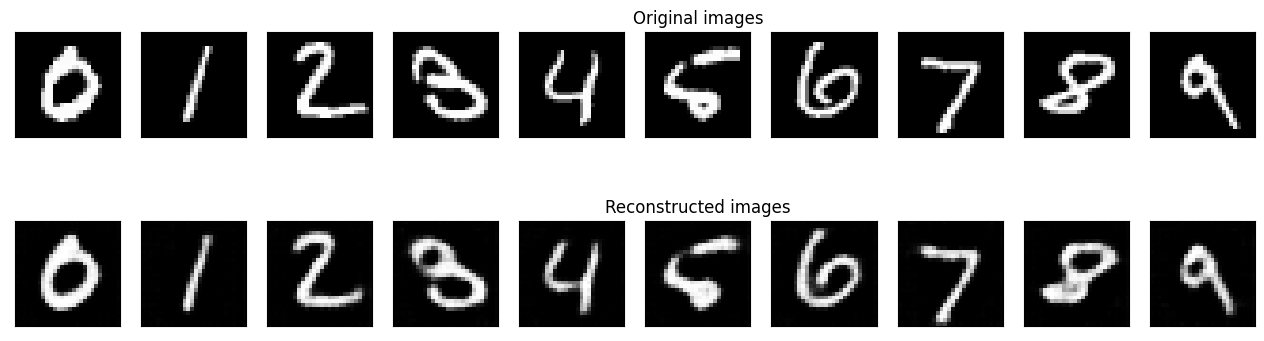

	 partial train loss (single batch): 0.006553
	 partial train loss (single batch): 0.007044
	 partial train loss (single batch): 0.006197
	 partial train loss (single batch): 0.007075
	 partial train loss (single batch): 0.006506
	 partial train loss (single batch): 0.006762
	 partial train loss (single batch): 0.006279
	 partial train loss (single batch): 0.006803
	 partial train loss (single batch): 0.006867
	 partial train loss (single batch): 0.006257
	 partial train loss (single batch): 0.006772
	 partial train loss (single batch): 0.006264
	 partial train loss (single batch): 0.006321
	 partial train loss (single batch): 0.006802
	 partial train loss (single batch): 0.006176
	 partial train loss (single batch): 0.006690
	 partial train loss (single batch): 0.006620
	 partial train loss (single batch): 0.007010
	 partial train loss (single batch): 0.006278
	 partial train loss (single batch): 0.006423
	 partial train loss (single batch): 0.006759
	 partial train loss (single batch

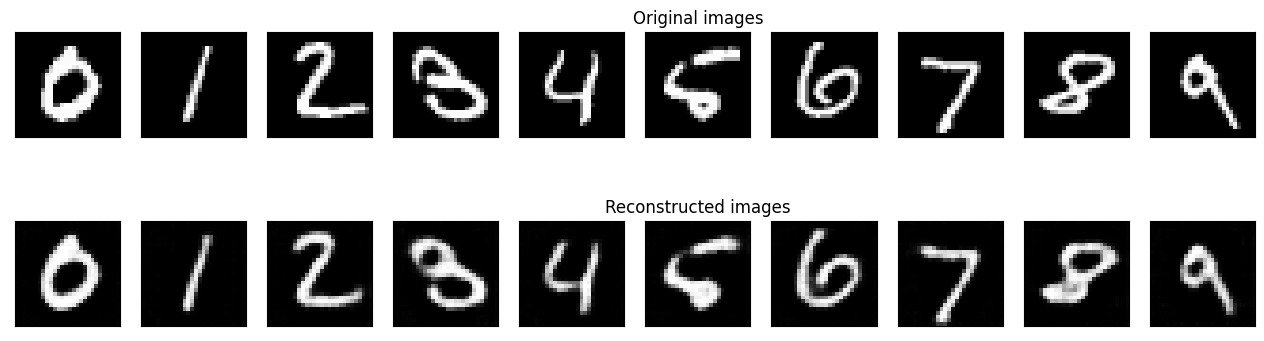

	 partial train loss (single batch): 0.006471
	 partial train loss (single batch): 0.006926
	 partial train loss (single batch): 0.006117
	 partial train loss (single batch): 0.006963
	 partial train loss (single batch): 0.006416
	 partial train loss (single batch): 0.006664
	 partial train loss (single batch): 0.006153
	 partial train loss (single batch): 0.006725
	 partial train loss (single batch): 0.006765
	 partial train loss (single batch): 0.006125
	 partial train loss (single batch): 0.006667
	 partial train loss (single batch): 0.006121
	 partial train loss (single batch): 0.006235
	 partial train loss (single batch): 0.006711
	 partial train loss (single batch): 0.006077
	 partial train loss (single batch): 0.006636
	 partial train loss (single batch): 0.006544
	 partial train loss (single batch): 0.006947
	 partial train loss (single batch): 0.006228
	 partial train loss (single batch): 0.006401
	 partial train loss (single batch): 0.006693
	 partial train loss (single batch

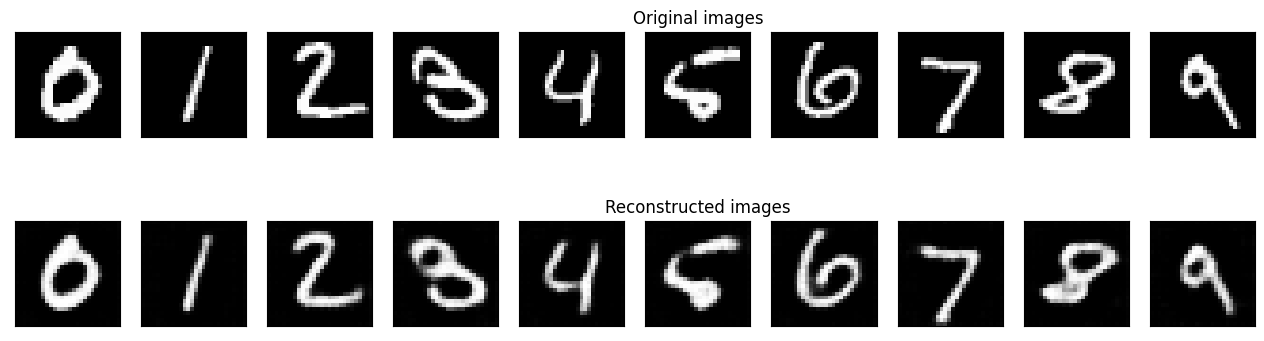

	 partial train loss (single batch): 0.006435
	 partial train loss (single batch): 0.006824
	 partial train loss (single batch): 0.006084
	 partial train loss (single batch): 0.006870
	 partial train loss (single batch): 0.006411
	 partial train loss (single batch): 0.006569
	 partial train loss (single batch): 0.006099
	 partial train loss (single batch): 0.006640
	 partial train loss (single batch): 0.006693
	 partial train loss (single batch): 0.006044
	 partial train loss (single batch): 0.006594
	 partial train loss (single batch): 0.006061
	 partial train loss (single batch): 0.006165
	 partial train loss (single batch): 0.006611
	 partial train loss (single batch): 0.006038
	 partial train loss (single batch): 0.006556
	 partial train loss (single batch): 0.006509
	 partial train loss (single batch): 0.006867
	 partial train loss (single batch): 0.006153
	 partial train loss (single batch): 0.006342
	 partial train loss (single batch): 0.006629
	 partial train loss (single batch

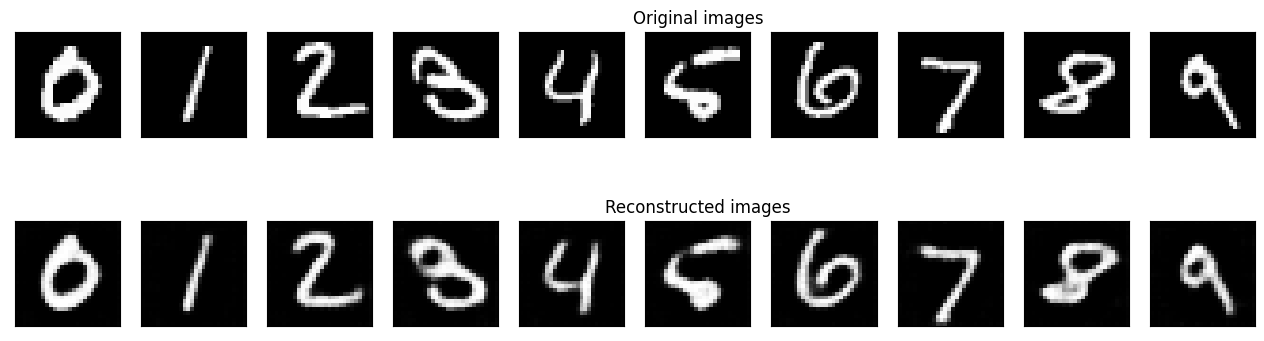

	 partial train loss (single batch): 0.006401
	 partial train loss (single batch): 0.006753
	 partial train loss (single batch): 0.006061
	 partial train loss (single batch): 0.006801
	 partial train loss (single batch): 0.006384
	 partial train loss (single batch): 0.006530
	 partial train loss (single batch): 0.006027
	 partial train loss (single batch): 0.006599
	 partial train loss (single batch): 0.006658
	 partial train loss (single batch): 0.005962
	 partial train loss (single batch): 0.006566
	 partial train loss (single batch): 0.005990
	 partial train loss (single batch): 0.006123
	 partial train loss (single batch): 0.006570
	 partial train loss (single batch): 0.005996
	 partial train loss (single batch): 0.006517
	 partial train loss (single batch): 0.006464
	 partial train loss (single batch): 0.006823
	 partial train loss (single batch): 0.006091
	 partial train loss (single batch): 0.006321
	 partial train loss (single batch): 0.006592
	 partial train loss (single batch

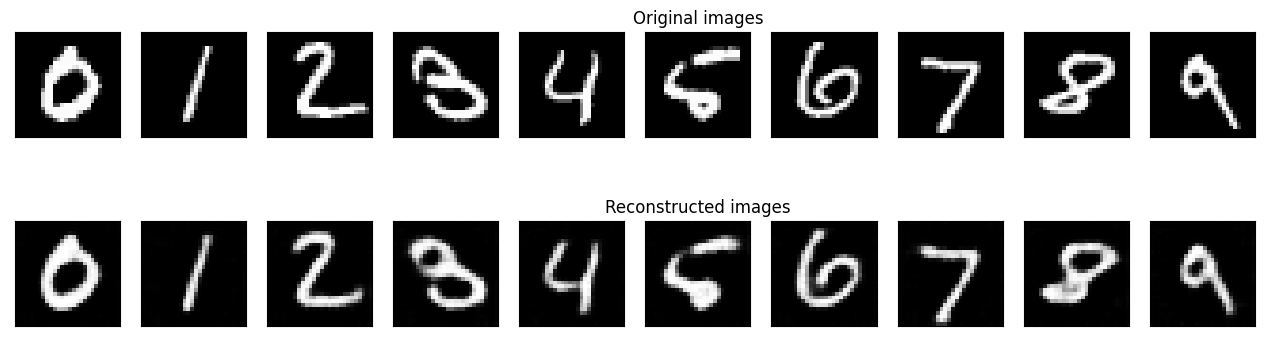

	 partial train loss (single batch): 0.006334
	 partial train loss (single batch): 0.006666
	 partial train loss (single batch): 0.006022
	 partial train loss (single batch): 0.006719
	 partial train loss (single batch): 0.006336
	 partial train loss (single batch): 0.006428
	 partial train loss (single batch): 0.005979
	 partial train loss (single batch): 0.006516
	 partial train loss (single batch): 0.006602
	 partial train loss (single batch): 0.005888
	 partial train loss (single batch): 0.006494
	 partial train loss (single batch): 0.005917
	 partial train loss (single batch): 0.006058
	 partial train loss (single batch): 0.006513
	 partial train loss (single batch): 0.005963
	 partial train loss (single batch): 0.006454
	 partial train loss (single batch): 0.006414
	 partial train loss (single batch): 0.006762
	 partial train loss (single batch): 0.006046
	 partial train loss (single batch): 0.006247
	 partial train loss (single batch): 0.006566
	 partial train loss (single batch

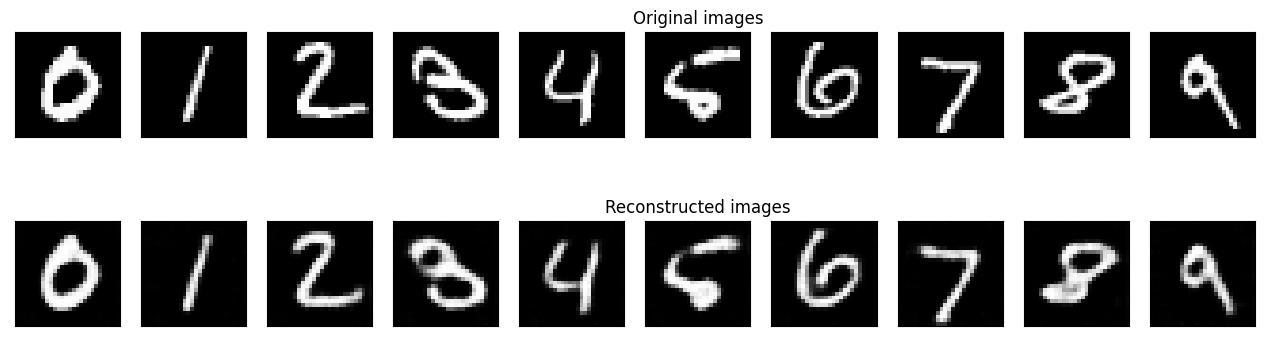

	 partial train loss (single batch): 0.006261
	 partial train loss (single batch): 0.006647
	 partial train loss (single batch): 0.005946
	 partial train loss (single batch): 0.006717
	 partial train loss (single batch): 0.006277
	 partial train loss (single batch): 0.006353
	 partial train loss (single batch): 0.005952
	 partial train loss (single batch): 0.006458
	 partial train loss (single batch): 0.006500
	 partial train loss (single batch): 0.005879
	 partial train loss (single batch): 0.006400
	 partial train loss (single batch): 0.005883
	 partial train loss (single batch): 0.005954
	 partial train loss (single batch): 0.006457
	 partial train loss (single batch): 0.005878
	 partial train loss (single batch): 0.006392
	 partial train loss (single batch): 0.006362
	 partial train loss (single batch): 0.006654
	 partial train loss (single batch): 0.005989
	 partial train loss (single batch): 0.006120
	 partial train loss (single batch): 0.006498
	 partial train loss (single batch

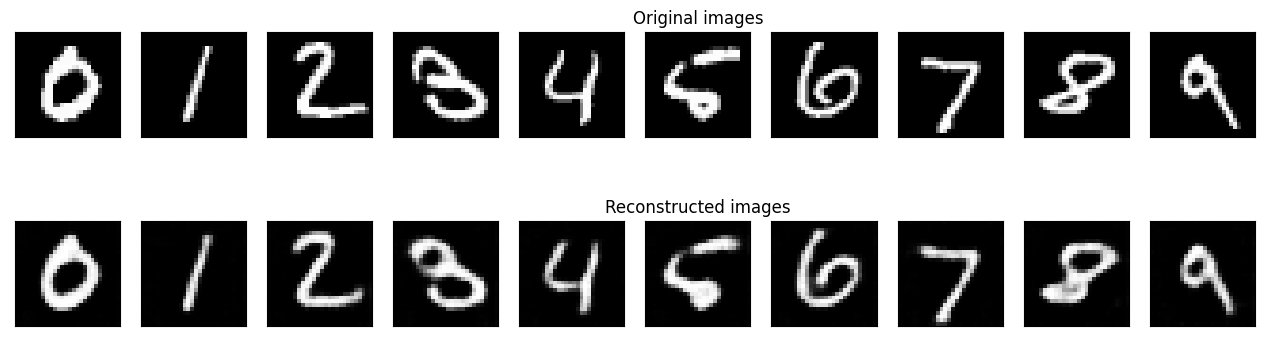

	 partial train loss (single batch): 0.006204
	 partial train loss (single batch): 0.006534
	 partial train loss (single batch): 0.005901
	 partial train loss (single batch): 0.006626
	 partial train loss (single batch): 0.006190
	 partial train loss (single batch): 0.006312
	 partial train loss (single batch): 0.005848
	 partial train loss (single batch): 0.006407
	 partial train loss (single batch): 0.006447
	 partial train loss (single batch): 0.005792
	 partial train loss (single batch): 0.006358
	 partial train loss (single batch): 0.005805
	 partial train loss (single batch): 0.005914
	 partial train loss (single batch): 0.006606
	 partial train loss (single batch): 0.006219
	 partial train loss (single batch): 0.006655
	 partial train loss (single batch): 0.006361
	 partial train loss (single batch): 0.006707
	 partial train loss (single batch): 0.006095
	 partial train loss (single batch): 0.006104
	 partial train loss (single batch): 0.006520
	 partial train loss (single batch

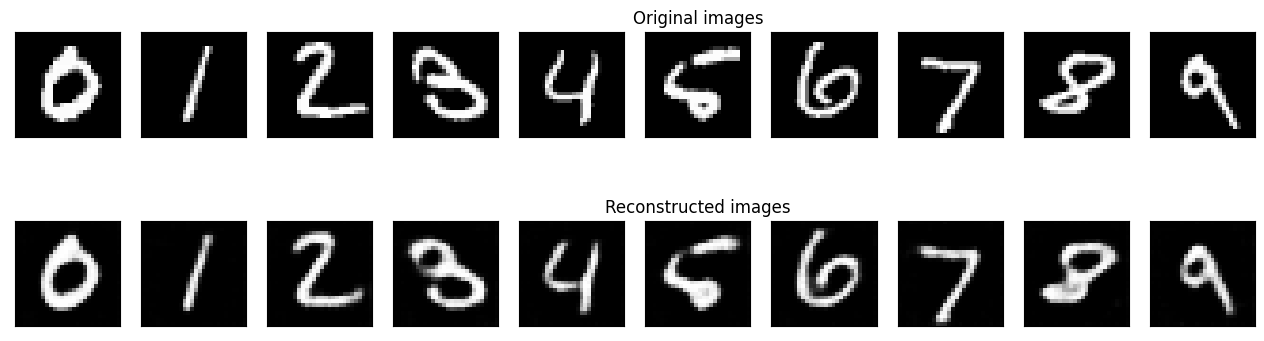

	 partial train loss (single batch): 0.006358
	 partial train loss (single batch): 0.006806
	 partial train loss (single batch): 0.005891
	 partial train loss (single batch): 0.007012
	 partial train loss (single batch): 0.006135
	 partial train loss (single batch): 0.006568
	 partial train loss (single batch): 0.005841
	 partial train loss (single batch): 0.006662
	 partial train loss (single batch): 0.006380
	 partial train loss (single batch): 0.006151
	 partial train loss (single batch): 0.006285
	 partial train loss (single batch): 0.005925
	 partial train loss (single batch): 0.005918
	 partial train loss (single batch): 0.006424
	 partial train loss (single batch): 0.005951
	 partial train loss (single batch): 0.006380
	 partial train loss (single batch): 0.006290
	 partial train loss (single batch): 0.006714
	 partial train loss (single batch): 0.005885
	 partial train loss (single batch): 0.006154
	 partial train loss (single batch): 0.006320
	 partial train loss (single batch

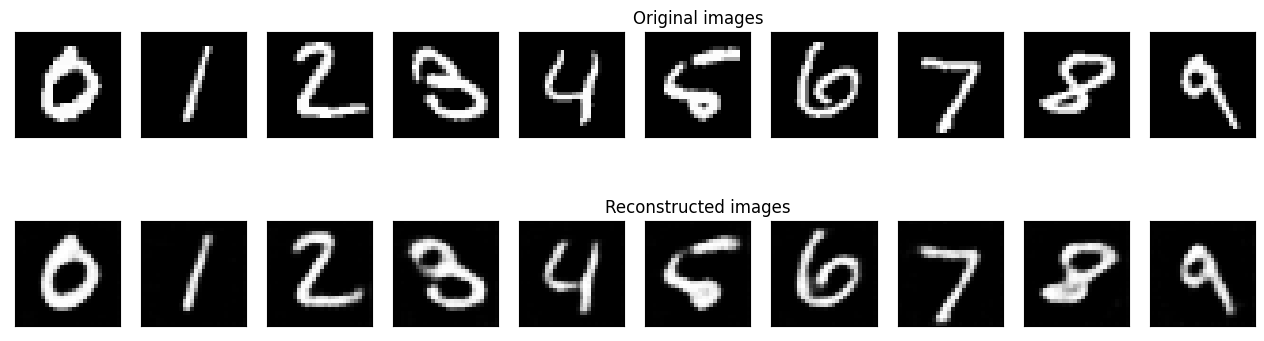

	 partial train loss (single batch): 0.006180
	 partial train loss (single batch): 0.006469
	 partial train loss (single batch): 0.005780
	 partial train loss (single batch): 0.006638
	 partial train loss (single batch): 0.006053
	 partial train loss (single batch): 0.006297
	 partial train loss (single batch): 0.005749
	 partial train loss (single batch): 0.006346
	 partial train loss (single batch): 0.006277
	 partial train loss (single batch): 0.005905
	 partial train loss (single batch): 0.006192
	 partial train loss (single batch): 0.005820
	 partial train loss (single batch): 0.005779
	 partial train loss (single batch): 0.006356
	 partial train loss (single batch): 0.005812
	 partial train loss (single batch): 0.006338
	 partial train loss (single batch): 0.006156
	 partial train loss (single batch): 0.006629
	 partial train loss (single batch): 0.005826
	 partial train loss (single batch): 0.006024
	 partial train loss (single batch): 0.006331
	 partial train loss (single batch

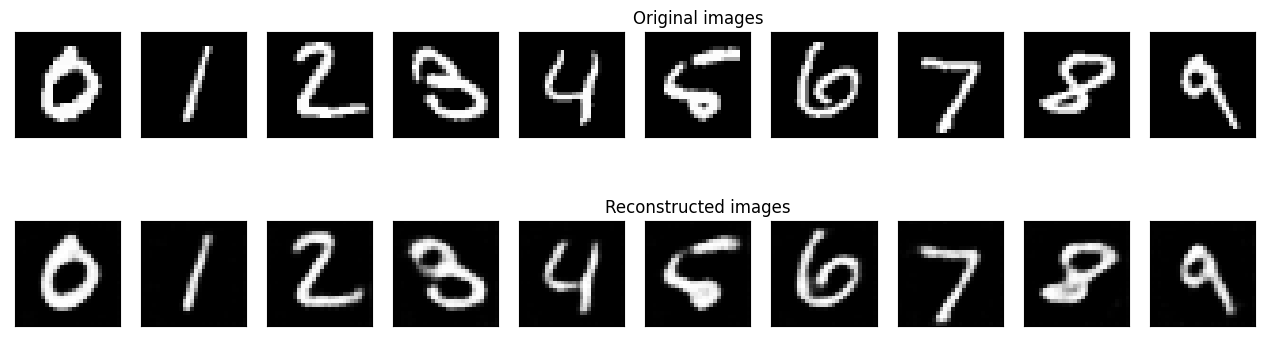

	 partial train loss (single batch): 0.006082
	 partial train loss (single batch): 0.006305
	 partial train loss (single batch): 0.005720
	 partial train loss (single batch): 0.006486
	 partial train loss (single batch): 0.005974
	 partial train loss (single batch): 0.006192
	 partial train loss (single batch): 0.005637
	 partial train loss (single batch): 0.006242
	 partial train loss (single batch): 0.006192
	 partial train loss (single batch): 0.005746
	 partial train loss (single batch): 0.006122
	 partial train loss (single batch): 0.005700
	 partial train loss (single batch): 0.005720
	 partial train loss (single batch): 0.006305
	 partial train loss (single batch): 0.005760
	 partial train loss (single batch): 0.006281
	 partial train loss (single batch): 0.006105
	 partial train loss (single batch): 0.006548
	 partial train loss (single batch): 0.005789
	 partial train loss (single batch): 0.005981
	 partial train loss (single batch): 0.006284
	 partial train loss (single batch

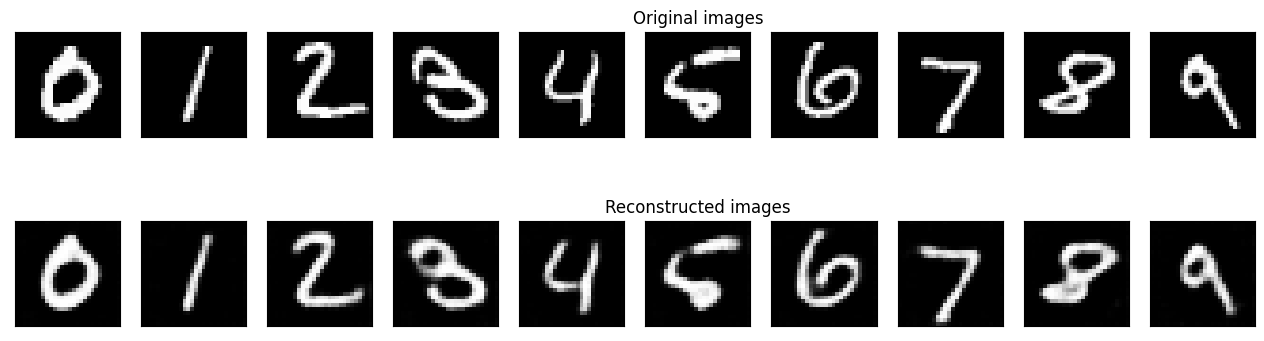

	 partial train loss (single batch): 0.006040
	 partial train loss (single batch): 0.006248
	 partial train loss (single batch): 0.005686
	 partial train loss (single batch): 0.006424
	 partial train loss (single batch): 0.005960
	 partial train loss (single batch): 0.006140
	 partial train loss (single batch): 0.005602
	 partial train loss (single batch): 0.006203
	 partial train loss (single batch): 0.006175
	 partial train loss (single batch): 0.005703
	 partial train loss (single batch): 0.006089
	 partial train loss (single batch): 0.005666
	 partial train loss (single batch): 0.005679
	 partial train loss (single batch): 0.006267
	 partial train loss (single batch): 0.005733
	 partial train loss (single batch): 0.006236
	 partial train loss (single batch): 0.006070
	 partial train loss (single batch): 0.006497
	 partial train loss (single batch): 0.005759
	 partial train loss (single batch): 0.005968
	 partial train loss (single batch): 0.006241
	 partial train loss (single batch

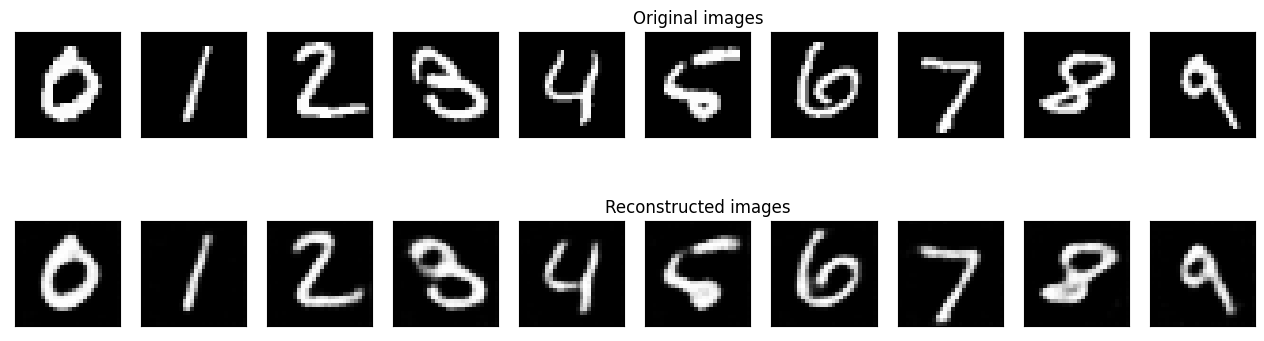

	 partial train loss (single batch): 0.005995
	 partial train loss (single batch): 0.006192
	 partial train loss (single batch): 0.005635
	 partial train loss (single batch): 0.006372
	 partial train loss (single batch): 0.005917
	 partial train loss (single batch): 0.006107
	 partial train loss (single batch): 0.005543
	 partial train loss (single batch): 0.006165
	 partial train loss (single batch): 0.006140
	 partial train loss (single batch): 0.005662
	 partial train loss (single batch): 0.006128
	 partial train loss (single batch): 0.006099
	 partial train loss (single batch): 0.005882
	 partial train loss (single batch): 0.006339
	 partial train loss (single batch): 0.005957
	 partial train loss (single batch): 0.006388
	 partial train loss (single batch): 0.006118
	 partial train loss (single batch): 0.006695
	 partial train loss (single batch): 0.005828
	 partial train loss (single batch): 0.006091
	 partial train loss (single batch): 0.006379
	 partial train loss (single batch

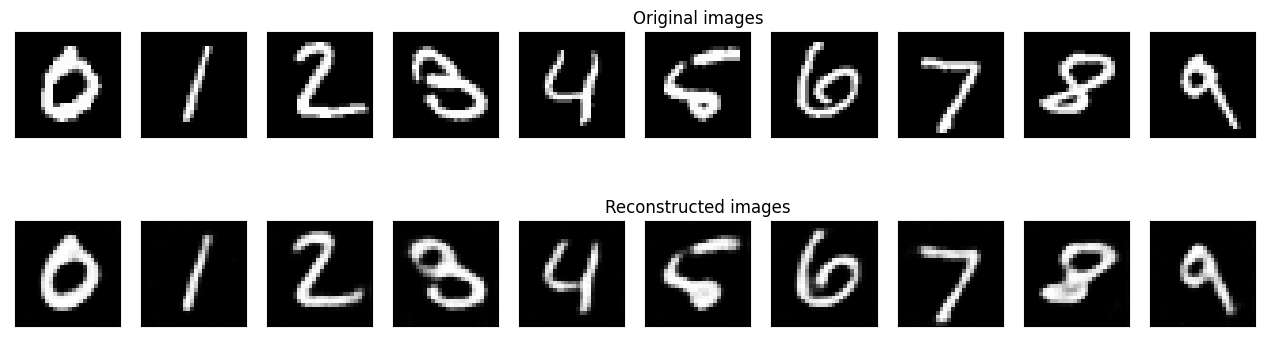

	 partial train loss (single batch): 0.005978
	 partial train loss (single batch): 0.006231
	 partial train loss (single batch): 0.005662
	 partial train loss (single batch): 0.006370
	 partial train loss (single batch): 0.005969
	 partial train loss (single batch): 0.006106
	 partial train loss (single batch): 0.005533
	 partial train loss (single batch): 0.006153
	 partial train loss (single batch): 0.006112
	 partial train loss (single batch): 0.005734
	 partial train loss (single batch): 0.006007
	 partial train loss (single batch): 0.005626
	 partial train loss (single batch): 0.005573
	 partial train loss (single batch): 0.006171
	 partial train loss (single batch): 0.005664
	 partial train loss (single batch): 0.006130
	 partial train loss (single batch): 0.005992
	 partial train loss (single batch): 0.006421
	 partial train loss (single batch): 0.005693
	 partial train loss (single batch): 0.005932
	 partial train loss (single batch): 0.006110
	 partial train loss (single batch

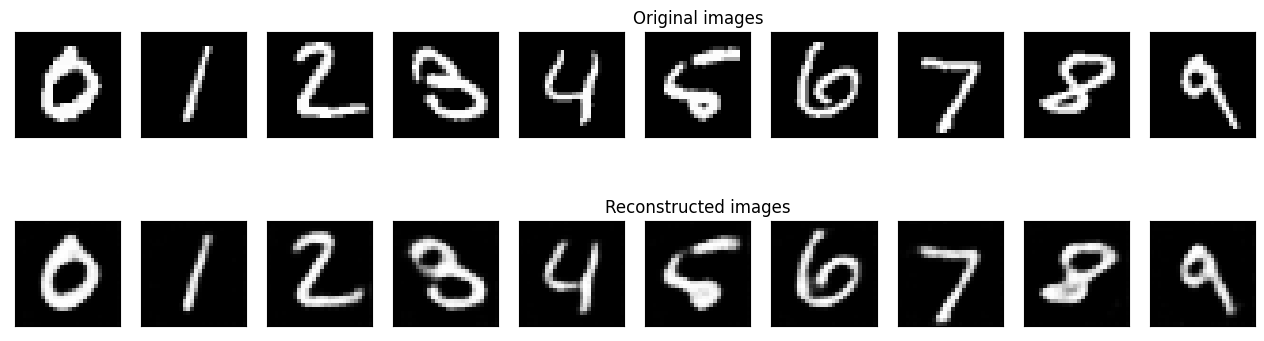

	 partial train loss (single batch): 0.005944
	 partial train loss (single batch): 0.006055
	 partial train loss (single batch): 0.005606
	 partial train loss (single batch): 0.006277
	 partial train loss (single batch): 0.005861
	 partial train loss (single batch): 0.006030
	 partial train loss (single batch): 0.005457
	 partial train loss (single batch): 0.006098
	 partial train loss (single batch): 0.006033
	 partial train loss (single batch): 0.005660
	 partial train loss (single batch): 0.005933
	 partial train loss (single batch): 0.005565
	 partial train loss (single batch): 0.005585
	 partial train loss (single batch): 0.006194
	 partial train loss (single batch): 0.005652
	 partial train loss (single batch): 0.006134
	 partial train loss (single batch): 0.006033
	 partial train loss (single batch): 0.006382
	 partial train loss (single batch): 0.005666
	 partial train loss (single batch): 0.005952
	 partial train loss (single batch): 0.006091
	 partial train loss (single batch

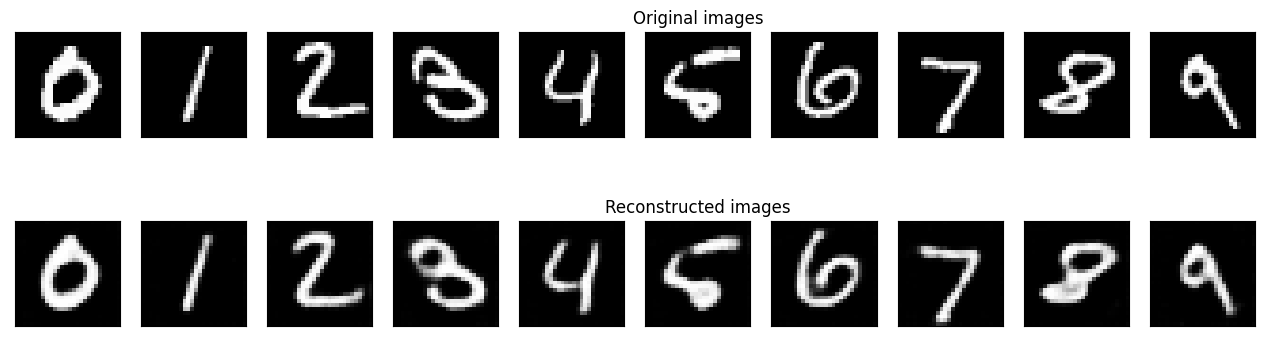

	 partial train loss (single batch): 0.005989
	 partial train loss (single batch): 0.006140
	 partial train loss (single batch): 0.005552
	 partial train loss (single batch): 0.006355
	 partial train loss (single batch): 0.005842
	 partial train loss (single batch): 0.006073
	 partial train loss (single batch): 0.005473
	 partial train loss (single batch): 0.006116
	 partial train loss (single batch): 0.006030
	 partial train loss (single batch): 0.005699
	 partial train loss (single batch): 0.005950
	 partial train loss (single batch): 0.005548
	 partial train loss (single batch): 0.005595
	 partial train loss (single batch): 0.006142
	 partial train loss (single batch): 0.005624
	 partial train loss (single batch): 0.006095
	 partial train loss (single batch): 0.005964
	 partial train loss (single batch): 0.006367
	 partial train loss (single batch): 0.005656
	 partial train loss (single batch): 0.005859
	 partial train loss (single batch): 0.006106
	 partial train loss (single batch

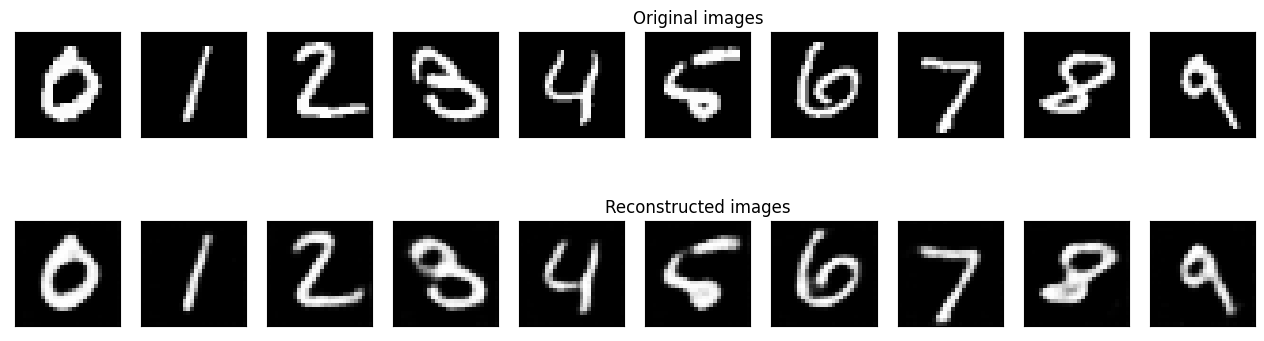

	 partial train loss (single batch): 0.005878
	 partial train loss (single batch): 0.005942
	 partial train loss (single batch): 0.005519
	 partial train loss (single batch): 0.006224
	 partial train loss (single batch): 0.005772
	 partial train loss (single batch): 0.005959
	 partial train loss (single batch): 0.005393
	 partial train loss (single batch): 0.006027
	 partial train loss (single batch): 0.005950
	 partial train loss (single batch): 0.005604
	 partial train loss (single batch): 0.005847
	 partial train loss (single batch): 0.005508
	 partial train loss (single batch): 0.005520
	 partial train loss (single batch): 0.006138
	 partial train loss (single batch): 0.005596
	 partial train loss (single batch): 0.006079
	 partial train loss (single batch): 0.005978
	 partial train loss (single batch): 0.006288
	 partial train loss (single batch): 0.005617
	 partial train loss (single batch): 0.005879
	 partial train loss (single batch): 0.006013
	 partial train loss (single batch

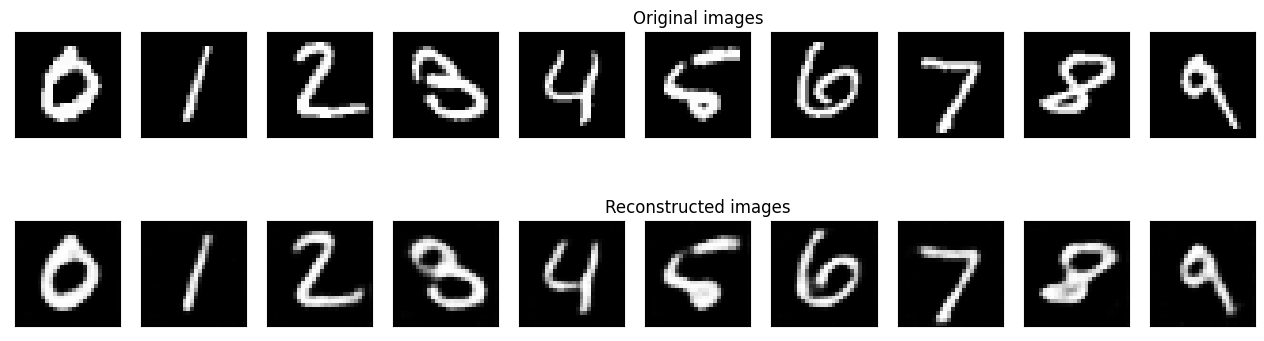

In [173]:
num_epochs = 40
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

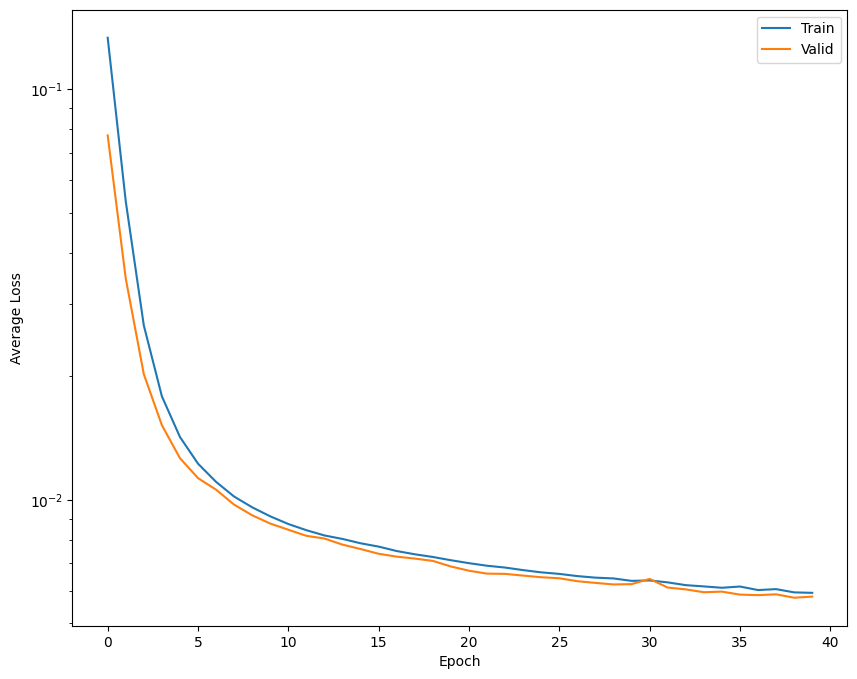

In [174]:
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

tensor([-0.0136,  0.0626,  0.0203, -0.1107, -0.0247,  0.0027,  0.0686,  0.0142,
         0.1851,  0.0028, -0.0049, -0.0077,  0.1065, -0.0020,  0.0064, -0.0452,
         0.0097, -0.0094, -0.0845,  0.0115, -0.0483, -0.0067, -0.0506, -0.0277,
        -0.1572,  0.0551,  0.0208,  0.0537,  0.0032, -0.0291,  0.0094, -0.0109])
tensor([0.1629, 0.1510, 0.1818, 0.1379, 0.1564, 0.1432, 0.1942, 0.1895, 0.1511,
        0.1373, 0.1537, 0.1778, 0.1895, 0.1627, 0.1484, 0.1450, 0.1873, 0.1560,
        0.1590, 0.1596, 0.1617, 0.1614, 0.1578, 0.1561, 0.1373, 0.1453, 0.1325,
        0.1759, 0.1468, 0.1837, 0.1351, 0.1364])


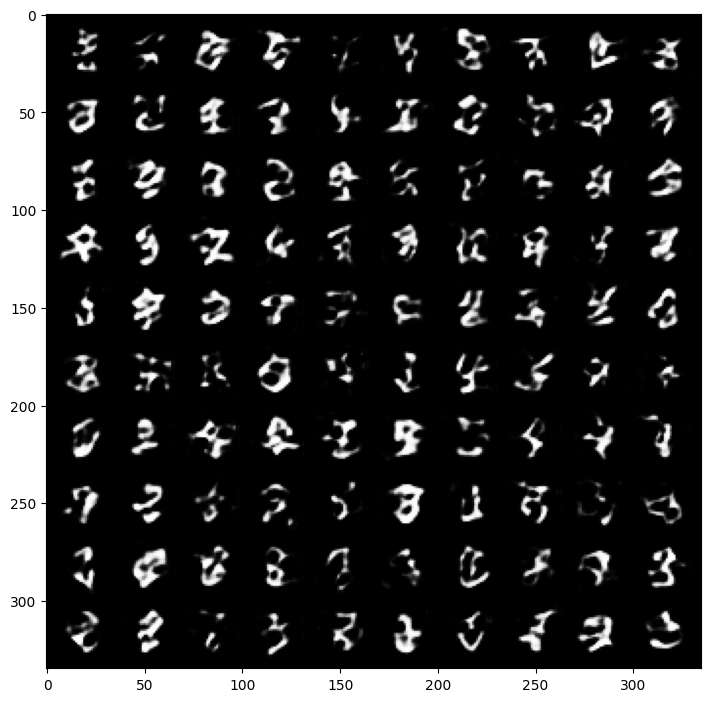

In [163]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs
    dataiter = iter(test_loader)
    images, small_images = next(dataiter)
    small_images = small_images.to(device)
    latent = encoder(small_images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

In [127]:
from tqdm import tqdm

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[1].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2056.73it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,...,Enc. Variable 55,Enc. Variable 56,Enc. Variable 57,Enc. Variable 58,Enc. Variable 59,Enc. Variable 60,Enc. Variable 61,Enc. Variable 62,Enc. Variable 63,label
0,-0.103982,-0.076670,0.090924,0.084103,0.097793,-0.111462,0.192919,-0.150047,-0.055400,-0.026998,...,0.138711,-0.034872,0.219927,0.130704,0.112779,-0.221847,0.118815,-0.080572,0.084959,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
1,-0.300548,0.189705,-0.109290,-0.036732,-0.022761,-0.013169,0.041483,0.021415,-0.129538,0.167601,...,0.008071,0.293772,-0.071787,0.011273,0.210063,0.026195,0.153470,0.139646,-0.080058,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
2,-0.078625,-0.144482,-0.092244,-0.038552,0.034925,-0.074379,-0.136935,-0.138183,-0.037527,-0.142015,...,0.087918,-0.046045,0.095198,-0.025872,0.166851,-0.024745,0.020868,0.020103,-0.039936,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
3,-0.089900,-0.042633,0.057844,-0.048209,-0.042962,-0.014527,0.296565,-0.052837,0.008793,-0.101465,...,0.015282,-0.010044,0.013392,-0.066916,-0.084016,-0.113061,-0.020364,0.049633,-0.260880,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
4,-0.129866,-0.083424,0.123418,0.247851,0.051366,0.028479,0.105549,0.051734,-0.000729,0.038147,...,0.124616,0.146215,0.017824,0.114215,-0.053545,0.007266,0.074920,0.073808,-0.042982,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.291475,0.166420,0.130244,-0.117623,-0.069313,-0.056112,0.094834,0.062500,0.020774,-0.096898,...,-0.066842,0.206509,0.090203,-0.022675,0.182420,-0.206808,0.016719,0.114936,0.013922,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
9996,-0.056297,0.034699,-0.009103,-0.233957,0.035677,0.109376,0.208291,0.008764,0.046884,-0.010764,...,0.026404,0.117163,0.226924,-0.093301,0.094352,-0.186716,0.028551,0.265070,-0.226480,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
9997,0.024798,0.071945,0.041372,-0.079860,0.024982,-0.139098,-0.183830,-0.202014,0.094602,-0.003065,...,-0.077398,-0.033008,0.058402,0.120732,-0.207095,-0.017642,0.085276,-0.113175,0.016925,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
9998,-0.114435,0.032509,-0.189186,0.133144,-0.006487,0.017952,0.105430,-0.311832,-0.058925,0.047087,...,-0.005069,0.001952,0.142858,0.068197,-0.062490,-0.241479,-0.044486,-0.062369,0.138922,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."


In [ ]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1',
           color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()